# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

In [2]:
%matplotlib inline

import os
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

# if not os.path.isdir('data'):
#     os.mkdir('data')

#download_and_extract('data', '.')

# Extracting Annotations from XML Format

In [3]:
xml_dir = 'data/annotations/xmls/'
xml_files = [os.path.join(xml_dir, x) for x in os.listdir(xml_dir) if x[-3:] == 'xml']
xml_files[0]

'data/annotations/xmls/newfoundland_133.xml'

In [3]:
classes = ['cat', 'dog']
categories = [
    {
        'class_id': 0,
        'name': 'cat'
    },
    {
        'class_id': 1,
        'name': 'dog'
    }
]

In [5]:
def extract_annotation(xml_file_path):
    
    tree = ET.parse(xml_file_path)
    root = tree.getroot()
    annotation = {}
    
    annotation['file'] = root.find('filename').text
    annotation['categories'] = categories
    
    size = root.find('size')
    
    annotation['image_size'] = [{
        'width': int(size.find('width').text),
        'height': int(size.find('height').text),
        'depth': int(size.find('depth').text)
    }]
    
    annotation['annotations'] = []
    
    for item in root.iter('object'):
        class_id = classes.index(item.find('name').text)
        ymin, xmin, ymax, xmax = None, None, None, None
        
        for box in item.findall('bndbox'):
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
        
            if all([xmin, ymin, xmax, ymax]) is not None:
                 annotation['annotations'].append({
                     'class_id': class_id,
                     'left': xmin,
                     'top': ymin,
                     'width': xmax - xmin,
                     'height': ymax - ymin
                 })
    return annotation

In [6]:
extract_annotation(xml_files[0])

{'file': 'newfoundland_133.jpg',
 'categories': [{'class_id': 0, 'name': 'cat'},
  {'class_id': 1, 'name': 'dog'}],
 'image_size': [{'width': 500, 'height': 375, 'depth': 3}],
 'annotations': [{'class_id': 1,
   'left': 237,
   'top': 83,
   'width': 98,
   'height': 86}]}

# Visualize Data

In [7]:
def plot_example(plt, annot, image_file_path, rows, cols, index):
    img = Image.open(image_file_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 20)
    
    for a in annot['annotations']:
        box = [
            int(a['left']), int(a['top']),
            int(a['left']) + int(a['width']),
            int(a['top']) + int(a['height'])
        ]
        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(a['class_id'])], font=font)
    plt.subplot(rows, cols, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    return plt

def show_random_annotations(plt):
    plt.figure(figsize=(16, 16))
    for i in range(0, 9):
        index = random.randint(0, len(xml_files) - 1)
        
        annot = extract_annotation(xml_files[index])
        image_file_path = os.path.join('data/images/', annot['file'])

        plt = plot_example(plt, annot, image_file_path, 3, 3, i)
    plt.show()

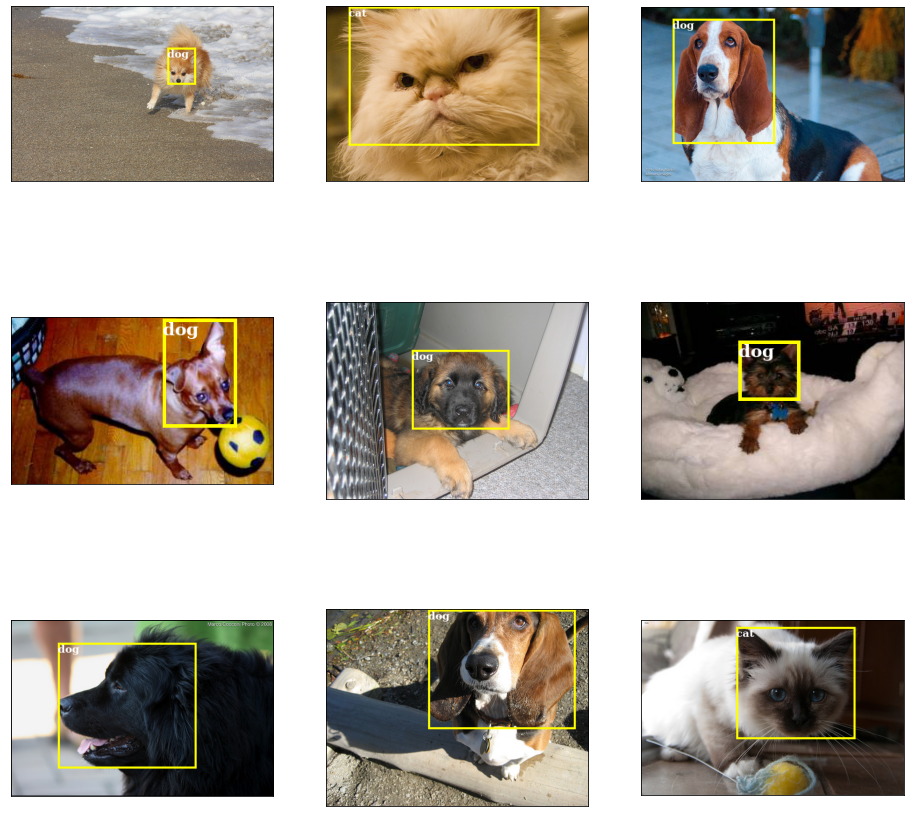

In [8]:
show_random_annotations(plt)

# SageMaker Setup

In [4]:
role = sagemaker.get_execution_role()
bucket_name = 'bankdemopractice'

training_image = get_image_uri(boto3.Session().region_name, 'object-detection',
                              repo_version='latest') # get docker image for training
print(training_image)

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


811284229777.dkr.ecr.us-east-1.amazonaws.com/object-detection:1


In [10]:
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [11]:
print('Total examples:', len(xml_files))

Total examples: 3686


In [12]:
for xml_file in tqdm(xml_files):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    annot = extract_annotation(xml_file)
    image_file_path = os.path.join('data/images/', annot['file'])
    image_target_path = os.path.join(target_set, annot['file'])
    shutil.copy(image_file_path, image_target_path)
    json_file_path = os.path.join(target_set + '_annotation', annot['file'][:-3] + 'json')
    with open(json_file_path, 'w') as f:
        json.dump(annot, f)

100%|██████████| 3686/3686 [00:02<00:00, 1420.28it/s]


In [4]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [10]:
print(len(train_annots), len(train_images))

NameError: name 'train_annots' is not defined

In [15]:
for image in train_images:
    key = image.split('.')[0]
    json_file = key + '.json'
    if json_file not in train_annots:
        print('Not found', json_file)

In [6]:
training_image

'991648021394.dkr.ecr.ap-south-1.amazonaws.com/object-detection:1'

# Uploading Data to S3

In [5]:
sess = sagemaker.Session()
#print(key)
#boto3.Session().resource("s3").Bucket(bucket).Object(key).upload_fileobj(fObj)
#s3 = boto3.resource('s3')

# print("Uploading data...")

# s3_train_path = sess.upload_data(path="train", bucket=bucket_name, key_prefix="train")
# print("Training images uploaded")
# s3_validation_path = sess.upload_data(path="validation", bucket=bucket_name, key_prefix="validation")
# print("Validation images uploaded")

# s3_train_annotation = sess.upload_data(path="train_annotation", bucket=bucket_name, key_prefix="train_annotation")
# print("Training annotations uploaded")
# s3_validation_annotation = sess.upload_data(path="validation_annotation", bucket=bucket_name, key_prefix="validation_annotation")
# print("Validation annotations uploaded")

In [6]:
s3_validation_annotation = "s3://bankdemopractice/validation_annotation/"
s3_train_path = "s3://bankdemopractice/train/"
s3_validation_path = "s3://bankdemopractice/validation/"
s3_train_annotation = "s3://bankdemopractice/train_annotation/"

In [7]:
role

'arn:aws:iam::158019657495:role/service-role/AmazonSageMaker-ExecutionRole-20220513T115804'

# SageMaker Estimator

In [8]:
model = sagemaker.estimator.Estimator(
    training_image,
    role=role,
    train_instance_type='ml.p3.2xlarge',
    train_instance_count=1,
    train_volume_size=100,
    train_max_run=36000,
    input_mode='File',
    output_path='s3://bankdemopractice/output',
    sagemaker_session=sess
)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_max_run has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_volume_size has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


# Hyperparameters

In [11]:
model.set_hyperparameters(
    base_network='resnet-50',
    num_classes=2,
    use_pretrained_model=1,
    mini_batch_size=16,
    epochs=2,
    learning_rate=0.001,
    optimizer='sgd',
    lr_scheduler_step='10',
    lr_scheduler_factor=0.1,
    momentum=0.9,
    weight_decay=0.0005,
    overlap_threshold=0.5,
    nms_threshold=0.45,
    image_shape=512,
    num_training_samples=2747
)

# Data Channels

In [12]:
train_data = sagemaker.session.s3_input(s3_train_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-image',
                                        s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_path,
                                        distribution='FullyReplicated',
                                        content_type='application/x-image',
                                        s3_data_type='S3Prefix')
train_annotation_data = sagemaker.session.s3_input(s3_train_annotation,
                                        distribution='FullyReplicated',
                                        content_type='application/x-image',
                                        s3_data_type='S3Prefix')
validation_annotation_data = sagemaker.session.s3_input(s3_validation_annotation,
                                        distribution='FullyReplicated',
                                        content_type='application/x-image',
                                        s3_data_type='S3Prefix')

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
data_channels = {
    'train': train_data,
    'validation': validation_data,
    'train_annotation': train_annotation_data,
    'validation_annotation': validation_annotation_data
}

In [14]:
data_channels

{'train': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fbd36467a20>,
 'validation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fbd364677b8>,
 'train_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fbd36467ac8>,
 'validation_annotation': <sagemaker.deprecations.deprecated_class.<locals>.DeprecatedClass at 0x7fbd36467b00>}

# Model Training

In [15]:
model.fit(inputs=data_channels, logs=True)

ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.p3.2xlarge for training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please contact AWS support to request an increase for this limit.

# Deploy Model

In [24]:
object_detector = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print("\nModel deployed!")

-------------------!
Model deployed!


# Predictions

In [25]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

930


In [28]:
index = 0

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = object_detector.predict(b, initial_args={"ContentType": "image/jpeg"})
results = json.loads(results)

preds = results['prediction']

In [29]:
preds[0]

[1.0,
 0.8942077159881592,
 0.05048900842666626,
 0.390957772731781,
 0.5912083387374878,
 0.6849502921104431]

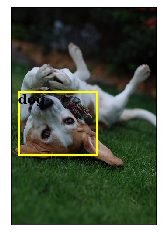

In [30]:
img = Image.open(image_path)
draw = ImageDraw.Draw(img)
font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 30)
w, h =img.size

for pred in preds:
    class_id, score, xmin, ymin, xmax, ymax = pred
    
    if score > 0.7:
        box = [w*xmin, h*ymin, w*xmax, h*ymax]

        draw.rectangle(box, outline='yellow', width=4)
        draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
    else:
        break

plt.xticks([])
plt.yticks([])
plt.imshow(img)
plt.show()

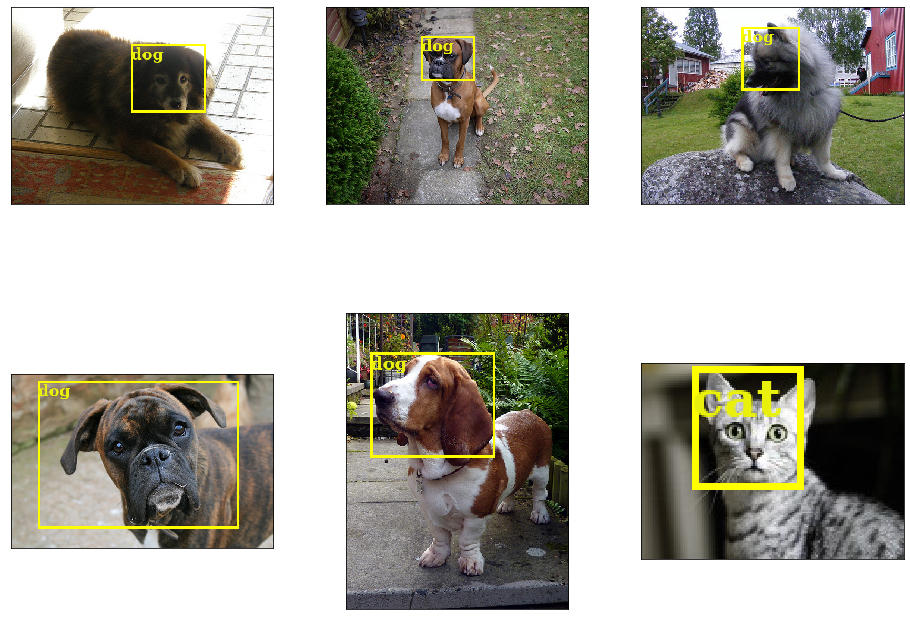

In [38]:
pic_indexes = [1, 54, 126, 200, 205, 327]
plt.figure(figsize=(16, 12))

for i, idx in enumerate(pic_indexes):
    img_path = image_path = os.path.join(image_dir, images[idx])
    
    with open(image_path, 'rb') as f:
        b = bytearray(f.read())
        
    results = object_detector.predict(b, initial_args={"ContentType": "image/jpeg"})
    results = json.loads(results)

    preds = results['prediction']
    
    img = Image.open(image_path)
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('/usr/share/fonts/dejavu/DejaVuSerif-Bold.ttf', 30)
    w, h = img.size
    
    for pred in preds:
        class_id, score, xmin, ymin, xmax, ymax = pred

        if score > 0.7:
            box = [w*xmin, h*ymin, w*xmax, h*ymax]

            draw.rectangle(box, outline='yellow', width=4)
            # draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill='#000000')
            draw.text((box[0], box[1]), classes[int(class_id)], font=font, fill=(232, 240, 12))
        else:
            break
    
    plt.subplot(2, 3, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
plt.show()

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(object_detector.endpoint_name)